# Gaussian Processes
In this notebook, I implement a simple Gaussian Process from scratch.

Useful resources:  
(1) [J Cunningham's lecture on GPs (youtube)](https://www.youtube.com/watch?v=BS4Wd5rwNwE)  
(2) [Ch 2 of Rasmussen & Williams' Gaussian Process Book (pdf)](http://www.gaussianprocess.org/gpml/chapters/RW2.pdf)  
(3) [Ch 6 of Bishop's PRML book (pdf)](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)  

GPs are nonparametric methods. In contrast to parametric Bayesian models that define a prior over parameters, a GP defines a prior over functions. In brief, they define a distribution (multivariate gaussian) over functions whose shape (smoothness) are characterised by a Kernel (covariance matrix).   
GP regression: You start with a prior over functions. By observing some function values, you turn this into a posterior over functions. Cool insight: Use of gaussians means that complicated bayesian framework boils down to very simple Linear Algebra. Downside: To update the prior, the inverse of a data matrix must be taken. Thus, inference rather slow.

In [54]:
import numpy as np

from numpy.linalg import cholesky, det, lstsq
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

plt.style.use("default")

In [62]:
# helper function
# inspired by https://github.com/krasserm/bayesian-machine-learning/blob/master/gaussian_processes_util.py

def plot_gps(mu, covmat, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(covmat))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.2)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'ro')
    plt.legend(bbox_to_anchor=(1.04,0.5),loc='center left')


## The Gaussian Process



### Introduction
A GP is a stochastic process that describes a distribution over functions whose smoothness is defined by a Kernel (i.e. covariance) function. In other words, each point $x \in \mathbb{R}^d$ is mapped onto a random variable $f(x)$. The joint distribution of these variables is itself gaussian:    

$$ 
p(f(x_1), f(x_2) ... f(x_n)) = p(f|X) =  \mathcal{N}(f|\mu,K)
$$


where $f = [f(x_1), f(x_2), ..., f(x_n)]$ and $\mu = [m(x_1), m(x_2), ..., m(x_n)]$ and $K_{ij} = \kappa(x_i,x_j)$.  Therefore, the space of possible functions is described by the sufficient statistics of a multivariate gaussian: The mean vector and covariance matrix.  It is common practice to set its mean functions to zero. In other words: $\mu = [m(x_1), m(x_2), ..., m(x_n)] = [0,0,....,0]$, as we usually don't have any prior information about the mean of the funcction we'd like to model. Note: This is equivalent to having a zero-mean prior on the weights in parametric regression approaches. 
 We assume the covariance matrix to be smooth, e.g. there is a slow decrease in covariance with distance from the diagonal. This has as consequence that if $x_i$ and $x_j$ are close together, the function values $f(x_i)$ and $f(x_j)$ sampled from the GP are also similar to each other.  

### The Kernel Function 
The kernel function is used to obtain a covariane matrix for a finite set of input values and therefore describes the smoothness of the modelled functions. 

#### RBF Kernel
In this example, we implement a GP with a Radial Basis Function (RBF) Kernel 

$$ \kappa(x_i,x_j) = \sigma^2_f e^{-\frac{1}{2l^2}(x_i-x_j)^T(x_i-x_j)} $$  
$\sigma_f$ scales the whole matrix.  
$l$ is the length parameter, which controls the smoothness of the function (how quickly covariance drops of with increasing distance between i and j)
  
    


In [6]:
def kernel(X1, X2, l=1.0, s_f=1.0):
       
    return s_f**2 * np.exp(-0.5 / l**2 * (np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)))


Let's draw samples from this GP!

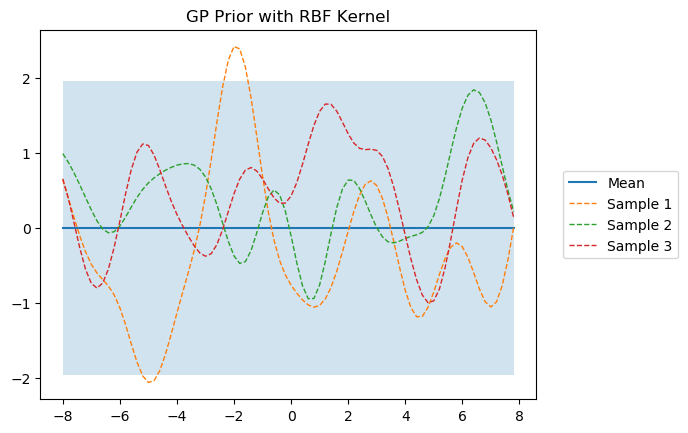

In [28]:
# Samples from GP with RBF kernel (very smooth) 
X = np.arange(-8, 8, .2)
X = np.expand_dims(X,1)
mu = np.zeros(X.shape)
covmat = kernel(X,X)
samples = np.random.multivariate_normal(mu.ravel(),covmat,3)
plot_gps(mu, covmat,X, samples=samples)
plt.title('GP Prior with RBF Kernel')
plt.show()

#### Ornstein-Uhlenbeck Kernel
The Ornstein-Uhlenbeck process was originally introduced to describe Brownian Motion (Uhlenbeck and Ornstein, 1930) and has the following form:
$$
\kappa(x_i,x_j) = exp(-\theta|x_i-x_j|) 
$$
Such an expontential kernel is ideal to model data that isn't very smooth, i.e. we expect that adjacent time-points aren't strongly correlated
Let's add it to our collection of kernels!

In [11]:
def kernel(X1, X2, l=1.0, s_f=1.0,ktype="rbf"):
    if ktype=="rbf":
        return s_f**2 * np.exp(-0.5 / l**2 * (np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)))
    elif ktype=="oup":
        return np.reshape([np.exp(-l*np.sum(np.abs(xi-xj))) for xi in X1 for xj in X2],(len(X1),len(X2)))



Let's have a look at samples from a GP with exponential kernel

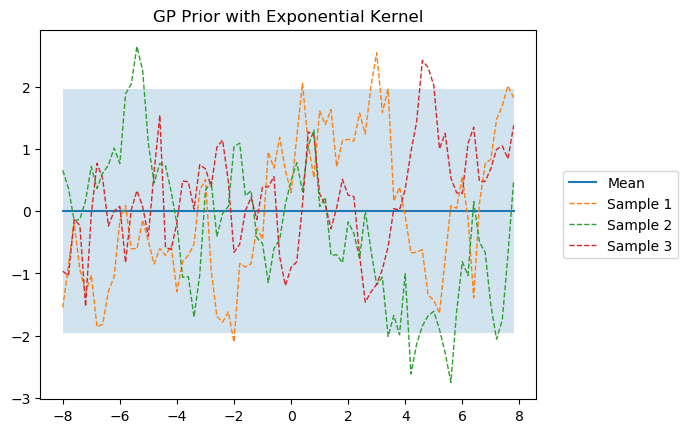

In [29]:
# Samples from GP with Exponential Kernel (not very smooth) 
X = np.arange(-8, 8, .2)
X = np.expand_dims(X,1)
mu = np.zeros(X.shape)
covmat = kernel(X,X,l=1,ktype="oup")
samples = np.random.multivariate_normal(mu.ravel(),covmat,3)
plot_gps(mu, covmat,X, samples=samples)
plt.title('GP Prior with Exponential Kernel')
plt.show()

### GP Regression
Let's assume that we have observed some data $y$. We'd like to update the GP to reflect this. in other words, the shape of the distribution over functions should be slightly biased towards our observed values.  
$Prior: p(f|X) $  
$Posterior: p(f|X,y)$  
#### Posterior Predictive distribution
The posterior can then be used to derive a posterior predictive distribution for new inputs, i.e. allows us to make new predicitions:  
$$ 
p(f_*|X_*, X, y) = \int{ p(f_*|X_*,f)p(f|X,y)} df  = \mathcal{N}(f_*|\mu_*,\Sigma_*)
$$
#### Joint of data and predictions  
Joint Distribution of Gaussians has nice property that it can be partitioned as follows. 

$$
\begin{pmatrix} 
y \\ f_*
\end{pmatrix} 
\sim \mathcal{N}
\left(0,
\begin{pmatrix}K_y & K_* \\ 
K_*^T & K_{**}
\end{pmatrix}
\right)
$$
where  
$$
K_y = \kappa(X,X) + \sigma^2_yI \\
K_* = \kappa(X,X_*) \\   
K_{**} = \kappa(X_*,X_*) 
$$
We assume $\sigma^2_y$ is the noise in $diag(K_y)$. For noise-free training targets, this is zero.

#### Sufficient Statistics of Posterior Predictive Distribution 
From the partitioning above, we can infer how to condition in order to obtain the posterior predictive distribution.
mean and covariance of $\mathcal{N}(f_*|\mu_*, \Sigma_*$ are defined as follows: 
$$ 
\mu_* = K^T_* K^{-1}_yy \\
\Sigma_* = K_{**} - K^T_*K^{-1}_y K_*
$$
Hence, inference is pure linear algebra, yet still in the bayesian framework (very neat!!!)

In [30]:
def sufficient_statistics(Xs, X, Y, l=1.0, s_f=1.0, s_y=1e-5,prior="rbf"):
    Ky = kernel(X,X,l,s_f,ktype=prior) + s_y**2*np.eye(len(X))
    Ks = kernel(X,Xs, l, s_f,ktype=prior)
    Kss = kernel(Xs,Xs, l ,s_f,ktype=prior)+ 1e-5 * np.eye(len(Xs))

    # mean 
    mu = Ks.T.dot(np.linalg.inv(Ky)).dot(Y)
    # covariance 
    covmat = Kss - Ks.T.dot(np.linalg.inv(Ky)).dot(Ks)
    return mu, covmat


### Posterior Predictive Distribution with RBF Kernel
Let's fit a Gp to some actual data. We assume that the ground truth follows a sine wave, which is rather smooth. Thus, an RBF Kernel appears to be a sensible choice!

Text(0.5, 1.0, 'Posterior Predictive Distribution of GP with RBF Kernel')

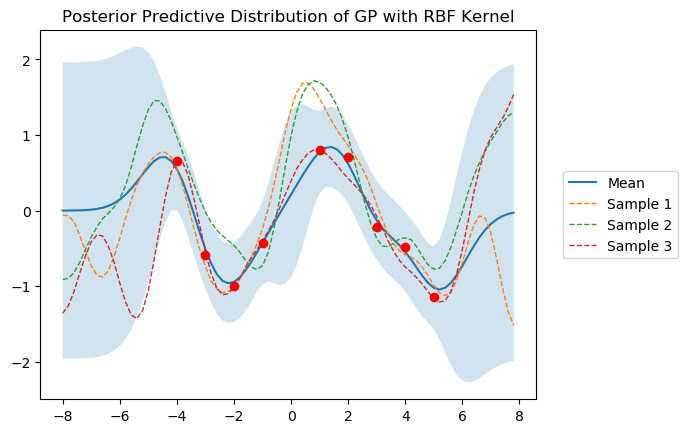

In [63]:
# Generate some training data
noise = 0.3
X_train = np.expand_dims(np.array([-4, -3, -2, -1, 1,2,3, 4,5]),axis=1)
Y_train = np.sin(X_train) + noise* np.random.randn(X_train.shape[0],1)

# Compute mean and covariance of the posterior predictive distribution
mu, covmat = sufficient_statistics(X, X_train, Y_train,prior="rbf",s_y=noise)

samples = np.random.multivariate_normal(mu.ravel(), covmat, 3)
plot_gps(mu, covmat, X, X_train=X_train, Y_train=Y_train, samples=samples)
plt.title('Posterior Predictive Distribution of GP with RBF Kernel')

#### Hyperparameters: Effect of Length Scale and Precision of Noise on Goodness of Fit
The length-parameter of the RBF Kernel controls the smoothness of the GP. Hence, it affects the overall flexibility of the estimated functions and can lead to over/underfitting:

Text(0.5, 1.0, 'RBF Kernel, length-scale 0.1')

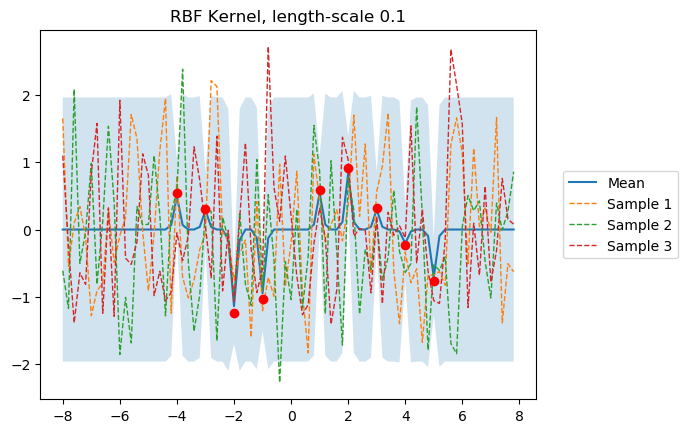

In [64]:
# Overfitting: Length Parameter too small. 
noise = 0.3
X_train = np.expand_dims(np.array([-4, -3, -2, -1, 1,2,3, 4,5]),axis=1)
Y_train = np.sin(X_train) + noise* np.random.randn(X_train.shape[0],1)
mu, covmat = sufficient_statistics(X, X_train, Y_train,prior="rbf",s_y=noise,l=0.1)
samples = np.random.multivariate_normal(mu.ravel(), covmat, 3)
plot_gps(mu, covmat, X, X_train=X_train, Y_train=Y_train, samples=samples)
plt.title('RBF Kernel, length-scale 0.1')

Text(0.5, 1.0, 'RBF Kernel, length-scale 10.0')

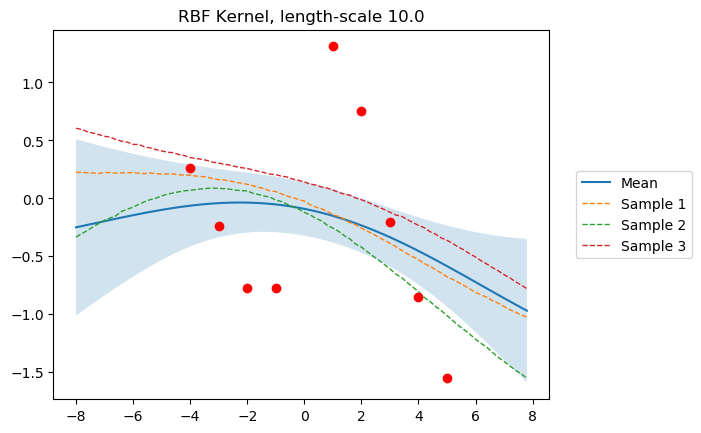

In [65]:
# Underfiting: Length Parameter too large
noise = 0.3
X_train = np.expand_dims(np.array([-4, -3, -2, -1, 1,2,3, 4,5]),axis=1)
Y_train = np.sin(X_train) + noise* np.random.randn(X_train.shape[0],1)
mu, covmat = sufficient_statistics(X, X_train, Y_train,prior="rbf",s_y=noise,l=10.0)
samples = np.random.multivariate_normal(mu.ravel(), covmat, 3)
plot_gps(mu, covmat, X, X_train=X_train, Y_train=Y_train, samples=samples)
plt.title('RBF Kernel, length-scale 10.0')

Likewise, a low precision of $\sigma_y$ allows the network to cover all variability in f, but not the timecourse of the underlying process:

Text(0.5, 1.0, 'RBF Kernel, $\\sigma_y$ 5')

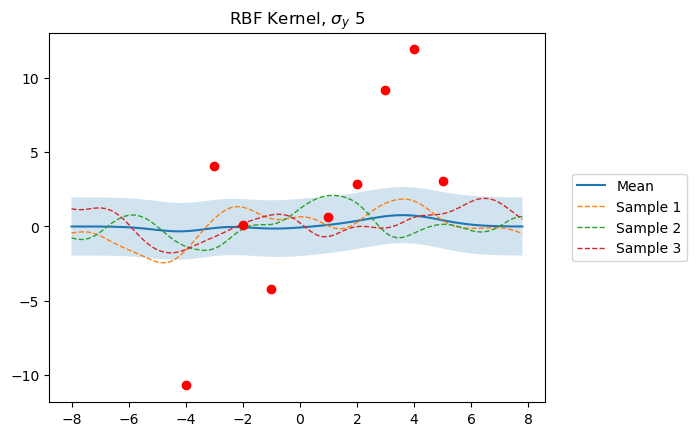

In [66]:
# Underfitting: Low Noise Precision
noise = 5
X_train = np.expand_dims(np.array([-4, -3, -2, -1, 1,2,3, 4,5]),axis=1)
Y_train = np.sin(X_train) + noise* np.random.randn(X_train.shape[0],1)
mu, covmat = sufficient_statistics(X, X_train, Y_train,prior="rbf",s_y=5)
samples = np.random.multivariate_normal(mu.ravel(), covmat, 3)
plot_gps(mu, covmat, X, X_train=X_train, Y_train=Y_train, samples=samples)
plt.title('RBF Kernel, $\sigma_y$ 5')

Text(0.5, 1.0, 'RBF Kernel, $\\sigma_y$ 0')

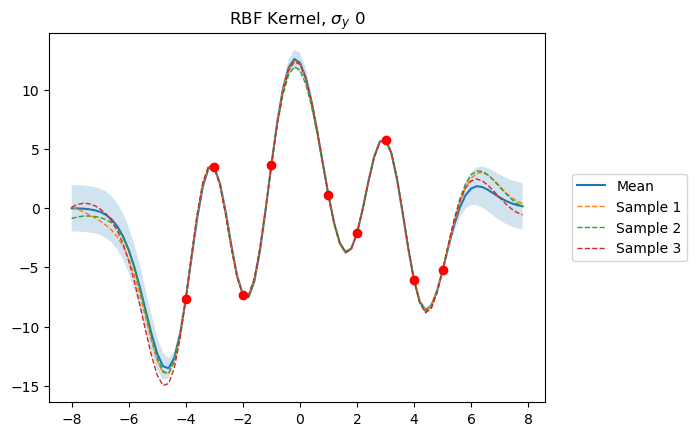

In [67]:
# Overfitting: High Noise Precision
noise = 5
X_train = np.expand_dims(np.array([-4, -3, -2, -1, 1,2,3, 4,5]),axis=1)
Y_train = np.sin(X_train) + noise* np.random.randn(X_train.shape[0],1)
mu, covmat = sufficient_statistics(X, X_train, Y_train,prior="rbf",s_y=0)
samples = np.random.multivariate_normal(mu.ravel(), covmat, 3)
plot_gps(mu, covmat, X, X_train=X_train, Y_train=Y_train, samples=samples)
plt.title('RBF Kernel, $\sigma_y$ 0')

### Posterior Predictive Distribution with Exponential Kernel
Just for fun, look at the fit with a rather unsmooth kernel (clearly a wrong prior in this case!):

Text(0.5, 1.0, 'GP Prior with Onrstein-Uhlenbeck Kernel')

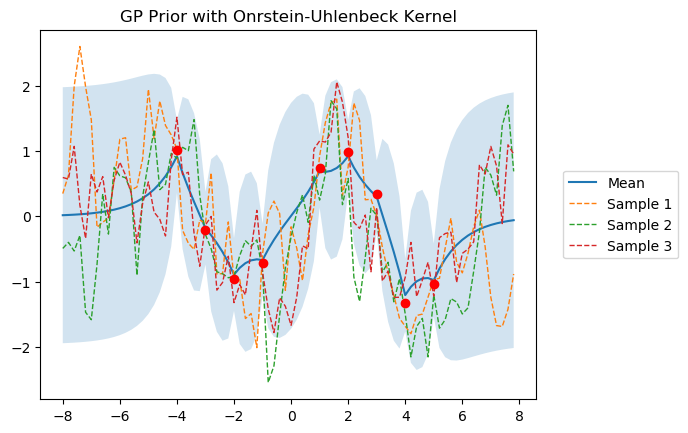

In [68]:
# Generate some training data
noise = 0.3
X_train = np.expand_dims(np.array([-4, -3, -2, -1, 1,2,3, 4,5]),axis=1)
Y_train = np.sin(X_train) + noise* np.random.randn(X_train.shape[0],1)

# Compute mean and covariance of the posterior predictive distribution
mu, covmat = sufficient_statistics(X, X_train, Y_train,prior="oup",s_y=noise)

samples = np.random.multivariate_normal(mu.ravel(), covmat, 3)
plot_gps(mu, covmat, X, X_train=X_train, Y_train=Y_train, samples=samples)
plt.title('GP Prior with Onrstein-Uhlenbeck Kernel')

## Hyperparameter Estimation
Above we have seen that the goodness of fit depends heavily on the Kernel function. However, even more important is the right choice of hyperparameters, as the kernel functions themselves are indeed quite flexible. 
Luckily, it's quite easy to derive the optimal hyperparameters, as we're only dealing with a multivariate Gaussian, for which we can easily optimise the log marginal likelihood.  
As a reminder, the standard form of the log-likelihood function for a multivariate gaussian is as follows:
$$
ln p(y|X,\theta) = ln \mathcal{N}(y|m,K_y,\theta) = -\frac{1}{2}ln|K_y| - \frac{1}{2}y^T K_y^{-1}y - \frac{N}{2}ln(2\pi)
$$

Finding the values for our hyperparameters that minimise this function is an optimisation problem, so we're gonna need its gradient:
$$ 
\frac{\partial}{\partial \theta_i} = - \frac{1}{2}Tr\left( K^{-1}_y \frac{\partial K_y}{\partial \theta_i} \right) + \frac{1}{2}y^T K_y^{-1} \frac{\partial K_y}{\partial\theta_i}K_y^{-1}y
$$ 

In the code below, we use BFGS to optimise the NLL function for its hyperparameters.



Text(0.5, 1.0, 'GP Posterior with RBF Kernel, best-fitting hyperparameters')

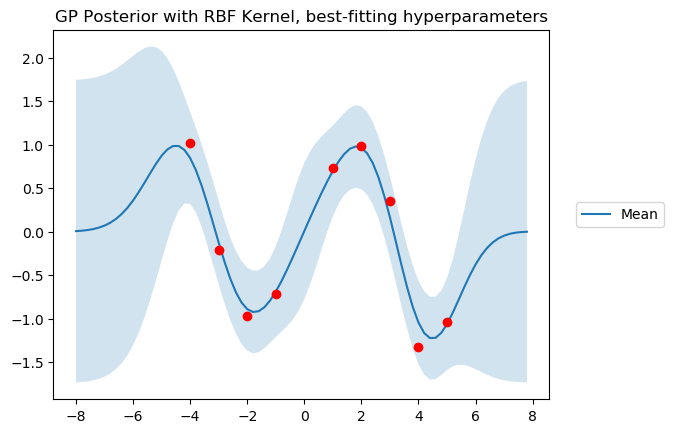

In [70]:
# this section relies heavily on http://www.gaussianprocess.org/gpml/chapters/RW2.pdf
# and an implementation found here: http://krasserm.github.io/2018/03/19/gaussian-processes/  
def objective_function(X_train, Y_train, noise):
    
    def loss(theta):        
        K = kernel(X_train, X_train, l=theta[0], s_f=theta[1]) + noise**2 * np.eye(len(X_train))
        L = cholesky(K)
        return np.sum(np.log(np.diagonal(L))) + 0.5 * Y_train.T.dot(lstsq(L.T, lstsq(L, Y_train,rcond=None)[0],rcond=None)[0]) +  0.5 * len(X_train) * np.log(2*np.pi)
    
    return loss

res = minimize(objective_function(X_train, Y_train, 0.3), [1, 1], bounds=((1e-5, None), (1e-5, None)), method='L-BFGS-B')

l_hat, s_f_hat = res.x


m_s, K_s = sufficient_statistics(X, X_train, Y_train, l=l_hat, s_f=s_f_hat, s_y=0.3)
plot_gps(m_s, K_s, X, X_train=X_train, Y_train=Y_train)
plt.title('GP Posterior with RBF Kernel, best-fitting hyperparameters')